# Task
Analyze and predict daily stock price movements (up/down) using historical data for a user-specified stock ticker, period, and lookback window for past returns. The analysis will involve downloading stock data, engineering features and a binary target label, training and evaluating both a neural network and a logistic regression model, comparing their performance using various metrics and visualizations, generating a next-day stock movement prediction, and providing an analysis with improvement suggestions. The trained neural network model will also be saved and an example for loading it will be provided.

## Notebook Setup and Instructions

### Subtask:
Install necessary libraries (yfinance, pandas, numpy, ta, sklearn, tensorflow, matplotlib, seaborn). Provide a 'How to use' section at the top of the notebook, explaining how to change the ticker, period, and N for past daily returns.


**Reasoning**:
Install the required Python libraries using pip.



In [ ]:
pip install yfinance pandas numpy ta scikit-learn tensorflow matplotlib seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fc41165d4cba46cc9e03705f80309e6f60a4bf380aad037f332bc6256bd2d56a
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


## How to Use This Notebook

To customize the stock analysis, you can easily modify the following parameters in the code cells below:

1.  **Stock Ticker**: Change the `ticker_symbol` variable to your desired stock (e.g., 'AAPL', 'MSFT', 'GOOG').
2.  **Historical Data Period**: Adjust the `data_period` variable to specify the duration of historical data to fetch (e.g., '5y' for 5 years, '10y' for 10 years, 'max' for maximum available data).
3.  **Lookback Window (N) for Past Daily Returns**: Modify the `n_past_returns` variable to set the number of previous days' returns to consider as features for prediction.

## Download Stock Data

### Subtask:
Download historical OHLC (Open, High, Low, Close) data for a user-defined stock ticker (default to 'AAPL') for the last 3 years using `yfinance`. Display the first few rows of the downloaded data.


**Reasoning**:
To download the historical stock data, I need to import the `yfinance` library, define the ticker symbol and data period, then use `yfinance.download()` to fetch the data, and finally display the head of the DataFrame to inspect the downloaded data.



In [ ]:
import yfinance as yf
import pandas as pd

# --- How to Use This Notebook: User-Customizable Parameters ---

# 1. Stock Ticker: Change to your desired stock (e.g., 'AAPL', 'MSFT', 'GOOG').
ticker_symbol = 'AAPL'

# 2. Historical Data Period: Adjust duration of historical data (e.g., '5y', '10y', 'max').
data_period = '3y'

# 3. Lookback Window (N) for Past Daily Returns: Number of previous days' returns to consider.
n_past_returns = 5  # Example: use the last 5 days' returns as features

print(f"Stock Ticker set to: {ticker_symbol}")
print(f"Historical Data Period set to: {data_period}")
print(f"Lookback Window for Past Returns (N) set to: {n_past_returns}")

# --- End of User-Customizable Parameters ---

# Download historical data using the defined parameters
df = yf.download(ticker_symbol, period=data_period)

# Display the first few rows of the downloaded data
print(f"\nDownloaded data for {ticker_symbol} for the last {data_period}:")
print(df.head())

Stock Ticker set to: AAPL
Historical Data Period set to: 3y
Lookback Window for Past Returns (N) set to: 5


/tmp/ipython-input-3713185924.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_symbol, period=data_period)
[*********************100%***********************]  1 of 1 completed


Downloaded data for AAPL for the last 3y:
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2022-11-15  147.810074  151.307316  146.352074  149.957682  89868300
2022-11-16  146.578674  147.642625  145.100967  146.913633  64218300
2022-11-17  148.480011  149.228711  143.977923  144.253760  80389400
2022-11-18  149.041519  150.430567  147.741145  150.046364  74829600
2022-11-21  145.810257  148.135183  145.524574  147.928312  58724100


**Reasoning**:
The previous steps successfully downloaded the historical stock data and defined the user-customizable parameters. The next logical step, as outlined in the overall task, is to perform feature engineering and create a binary target label for the stock price movement prediction.



## Feature and Label Engineering

### Subtask:
Calculate daily percentage returns, create a binary target label indicating the next day's price movement (up/down), and generate lagged daily returns as features.


## Feature Engineering and Target Label Creation

### Subtask:
Calculate daily percentage returns, create a binary target label indicating the next day's price movement (up/down), and generate lagged daily returns as features.

#### Instructions:
1.  Calculate daily percentage returns for the 'Close' price and store them in a new column called 'Daily_Return'.
2.  Create the target variable `Target`, which will be `1` if the next day's 'Close' price is higher than the current day's 'Close' price, and `0` otherwise. Handle the last row which won't have a next day's price.
3.  Generate `n_past_returns` lagged daily returns as features (e.g., 'Return_Lag_1', 'Return_Lag_2', ..., 'Return_Lag_N') based on the `Daily_Return` column.
4.  Drop any rows with `NaN` values that resulted from the lagging operations.
5.  Display the first few rows of the DataFrame with the new features and target variable.

**Reasoning**:
Now that the instructions are correctly in a markdown cell, I will implement the feature engineering and target label creation in a new code cell as per the subtask requirements. This involves calculating daily returns, creating a binary target, generating lagged returns, and cleaning up NaN values.



In [ ]:
import pandas as pd

# Rename columns to remove the ticker symbol suffix (e.g., 'Close_AAPL' becomes 'Close')
df.columns = [col.replace(f'_{ticker_symbol}', '') for col in df.columns]

# 1. Calculate daily percentage returns for the 'Close' price
df['Daily_Return'] = df['Close'].pct_change() * 100

# 2. Create the target variable 'Target'
# Target is 1 if next day's Close price is higher, 0 otherwise
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Handle the last row which won't have a next day's price for Target
df.loc[df.index[-1], 'Target'] = 0 # Assume no movement or set to 0. Can be dropped later if preferred

# 3. Generate n_past_returns lagged daily returns as features
for i in range(1, n_past_returns + 1):
    df[f'Return_Lag_{i}'] = df['Daily_Return'].shift(i)

# 4. Drop any rows with NaN values that resulted from the lagging operations and create an explicit copy
df_processed = df.dropna().copy()

# Ensure Target is integer type after dropping NaNs
df_processed['Target'] = df_processed['Target'].astype(int)

# 5. Display the first few rows of the DataFrame with the new features and target variable
print("DataFrame with new features and target variable:")
print(df_processed.head())

DataFrame with new features and target variable:
                 Close        High         Low        Open     Volume  \
Date                                                                    
2022-11-23  148.824799  149.573498  147.120499  147.228865   58301400   
2022-11-25  145.908798  146.667359  144.933506  146.105823   35195900   
2022-11-28  142.076614  144.460647  141.249102  142.982940   69246000   
2022-11-29  139.071945  142.657847  138.264140  142.145571   83763800   
2022-11-30  145.829956  146.509704  138.461129  139.298487  111380900   

            Daily_Return  Target  Return_Lag_1  Return_Lag_2  Return_Lag_3  \
Date                                                                         
2022-11-23      0.592641       0      1.466112     -2.168028      0.378171   
2022-11-25     -1.959351       0      0.592641      1.466112     -2.168028   
2022-11-28     -2.626424       0     -1.959351      0.592641      1.466112   
2022-11-29     -2.114823       1     -2.626424   

## Prepare Data for Modeling

### Subtask:
Perform a time-series train/test split on the dataset, allocating 80% for training and 20% for testing. Scale the features using `StandardScaler` to normalize their ranges.


**Reasoning**:
The subtask requires performing a time-series train/test split and scaling the features. I will implement these steps by first separating features and target, calculating the split point to maintain chronological order, then splitting the data, and finally using `StandardScaler` to fit on the training data and transform both training and testing sets.



In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Separate the features (X) and the target variable (y)
# Features are 'Daily_Return' and 'Return_Lag_X' columns
feature_columns = ['Daily_Return'] + [f'Return_Lag_{i}' for i in range(1, n_past_returns + 1)]
X = df_processed[feature_columns]
y = df_processed['Target']

# 2. Determine the size of the training and testing sets (80% train, 20% test)
split_point = int(len(X) * 0.8)

# 3. Split the features (X) and target (y) into X_train, X_test, y_train, and y_test
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# 4. Initialize a StandardScaler object
scaler = StandardScaler()

# 5. Fit the scaler to X_train and then transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames, preserving column names and index
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nScaled X_train head:")
print(X_train.head())
print("\nScaled X_test head:")
print(X_test.head())

X_train shape: (597, 6)
X_test shape: (150, 6)
y_train shape: (597,)
y_test shape: (150,)

Scaled X_train head:
            Daily_Return  Return_Lag_1  Return_Lag_2  Return_Lag_3  \
Date                                                                 
2022-11-23      0.315609      0.841593     -1.338003      0.221227   
2022-11-25     -1.203342      0.319526      0.842936     -1.427249   
2022-11-28     -1.600385     -1.205781      0.318744      0.925589   
2022-11-29     -1.295879     -1.604486     -1.212771      0.360081   
2022-11-30      2.855170     -1.298706     -1.613098     -1.292146   

            Return_Lag_4  Return_Lag_5  
Date                                    
2022-11-23      0.816193     -0.580403  
2022-11-25      0.216221      0.816910  
2022-11-28     -1.446120      0.214117  
2022-11-29      0.926507     -1.456041  
2022-11-30      0.356243      0.927743  

Scaled X_test head:
            Daily_Return  Return_Lag_1  Return_Lag_2  Return_Lag_3  \
Date               

## Build and Train Neural Network

### Subtask:
Build a small feedforward neural network using TensorFlow/Keras with the architecture: Dense(32) -> Dense(16) -> Dense(1) with a sigmoid activation for the output layer. Compile the model with the Adam optimizer and Binary Cross-entropy loss. Train the neural network for approximately 30 epochs with early stopping based on validation loss. Plot the training loss and accuracy curves over epochs.


**Reasoning**:
The subtask requires building, training, and visualizing the training process of a neural network. This involves importing TensorFlow/Keras modules, defining the model architecture, compiling it, setting up early stopping, training the model, and then plotting the training and validation loss and accuracy from the history object.



Neural Network Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


Training the Neural Network...
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5165 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.7120
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5267 - loss: 0.6872 - val_accuracy: 0.5250 - val_loss: 0.7143
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5741 - loss: 0.6826 - val_accuracy: 0.5500 - val_loss: 0.7153
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5505 - loss: 0.6871 - val_accuracy: 0.5333 - val_loss: 0.7168
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5590 - loss: 0.6812 - val_accuracy: 0.5250 - val_loss: 0.7196
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5712 - loss: 0.6773 - val_accuracy: 0.5417 - val_loss: 0.7212


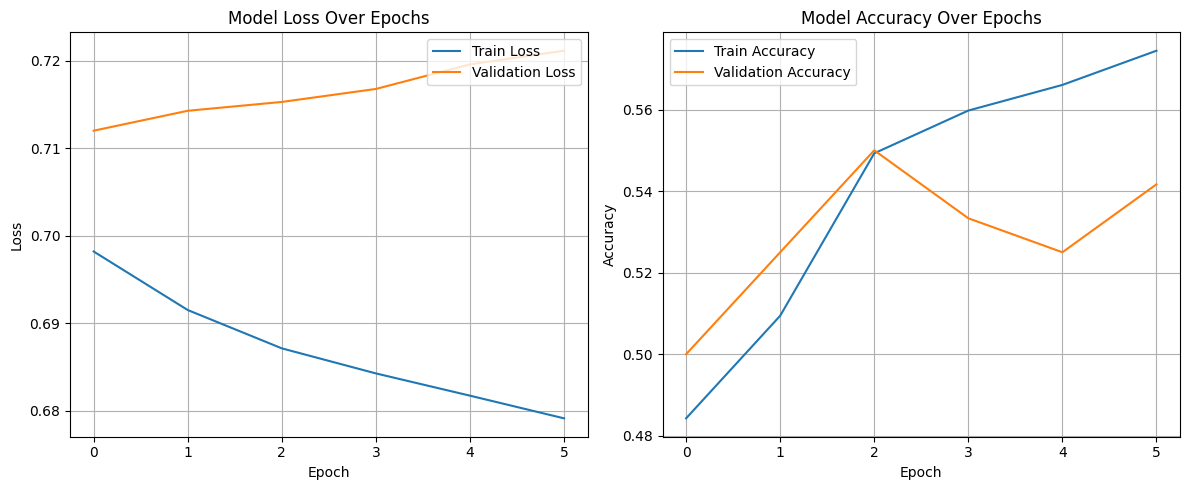


Neural Network training complete and plots displayed.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# 1. Get the number of features for input_shape
num_features = X_train.shape[1]

# 2. Create a Sequential model
model = Sequential([
    # Add an Input layer explicitly
    Input(shape=(num_features,)),
    # 3. Add a Dense layer with 32 units and 'relu' activation
    Dense(32, activation='relu'),
    # 4. Add another Dense layer with 16 units and 'relu' activation
    Dense(16, activation='relu'),
    # 5. Add a final Dense layer with 1 unit and 'sigmoid' activation for binary classification
    Dense(1, activation='sigmoid')
])

# 6. Compile the model using the 'adam' optimizer and 'binary_crossentropy' loss function.
#    Include 'accuracy' as a metric.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
print("Neural Network Model Summary:")
model.summary()

# 7. Initialize EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 8. Train the model
print("\nTraining the Neural Network...")
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 9. Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# 10. Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nNeural Network training complete and plots displayed.")

## Train Logistic Regression Baseline

### Subtask:
Train a logistic regression model as a baseline using `sklearn`. Display the coefficients of the logistic regression model, highlighting the top coefficients.


**Reasoning**:
The subtask requires training a logistic regression model, extracting its coefficients, and displaying them in a sorted DataFrame. I will implement these steps as outlined in the instructions.



In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# 1. Instantiate a LogisticRegression model
# Using 'liblinear' solver which is good for small datasets and L1/L2 regularization
# Setting random_state for reproducibility
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)

# 2. Fit the logistic regression model to the scaled training data
print("Training Logistic Regression Model...")
log_reg_model.fit(X_train, y_train)
print("Logistic Regression Model training complete.")

# 3. Extract the coefficients and intercept
coefficients = log_reg_model.coef_[0]
intercept = log_reg_model.intercept_[0]

# 4. Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Add the intercept to the DataFrame
intercept_df = pd.DataFrame([{'Feature': 'Intercept', 'Coefficient': intercept}])
coef_df = pd.concat([coef_df, intercept_df], ignore_index=True)

# 5. Sort the coefficients by their absolute values in descending order
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

# 6. Print the sorted DataFrame of coefficients
print("\nLogistic Regression Model Coefficients (Sorted by Absolute Value):")
print(coef_df_sorted)


Training Logistic Regression Model...
Logistic Regression Model training complete.

Logistic Regression Model Coefficients (Sorted by Absolute Value):
        Feature  Coefficient
6     Intercept     0.164620
0  Daily_Return     0.101911
4  Return_Lag_4    -0.080378
5  Return_Lag_5     0.061192
2  Return_Lag_2     0.051610
1  Return_Lag_1     0.049581
3  Return_Lag_3    -0.031003


## Evaluate and Compare Models

### Subtask:
Evaluate both the neural network and logistic regression models on the test set. Calculate and display key classification metrics: accuracy, precision, recall, F1-score, and ROC AUC for both models. Generate and display confusion matrices for both models. Plot the ROC curves for both models on the same plot for comparison. Create a bar chart comparing the calculated metrics (accuracy, precision, recall, F1, ROC AUC) for both models. Generate histograms or Kernel Density Estimate (KDE) plots of the predicted probabilities for both models to visualize their distributions.


**Reasoning**:
The subtask requires evaluating and comparing the neural network and logistic regression models using various classification metrics, confusion matrices, ROC curves, and probability distribution plots. I will implement all these evaluation steps in a single code block to provide a comprehensive comparison.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Neural Network Predictions Sample: [1 0 1 1 0]
Logistic Regression Predictions Sample: [1 0 1 0 1]

--- Model Performance Metrics ---

Neural Network:
  Accuracy: 0.5400
  Precision: 0.5783
  Recall: 0.5854
  F1-Score: 0.5818
  ROC AUC: 0.5445

Logistic Regression:
  Accuracy: 0.5733
  Precision: 0.5682
  Recall: 0.9146
  F1-Score: 0.7009
  ROC AUC: 0.5502

--- Neural Network Classification Report ---
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        68
           1       0.58      0.59      0.58        82

    accuracy                           0.54       150
   macro avg       0.54      0.54      0.54       150
weighted avg       0.54      0.54      0.54       150


--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.61      0.16      0.26        68
           1       0.57      0.91      0.70        82

    accuracy   

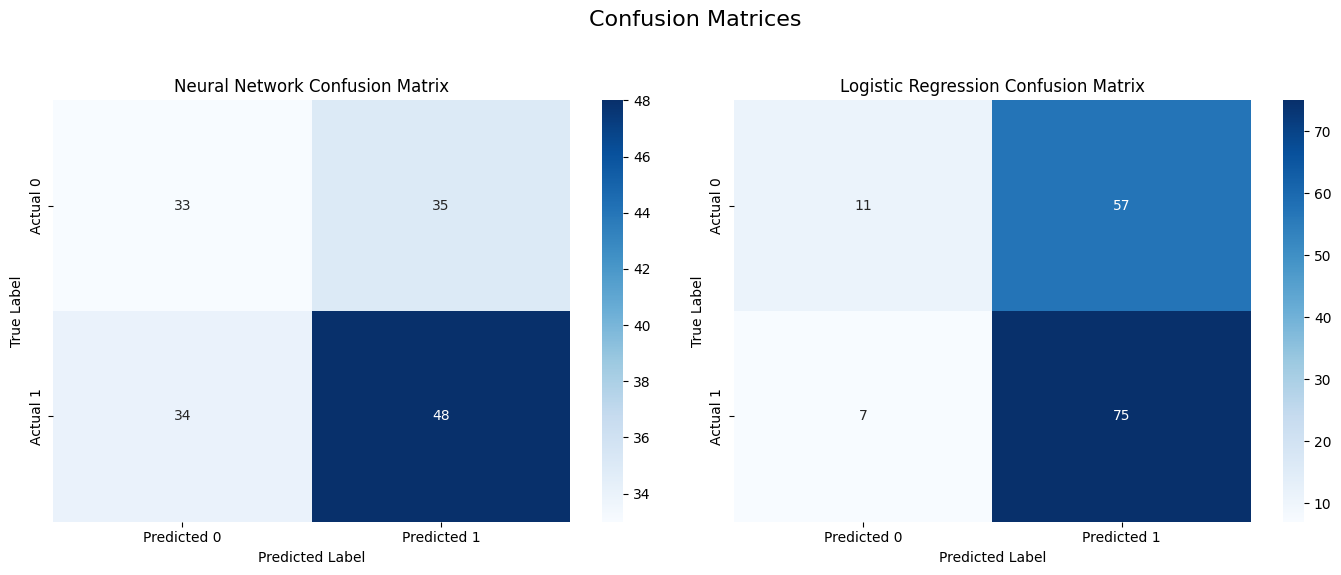

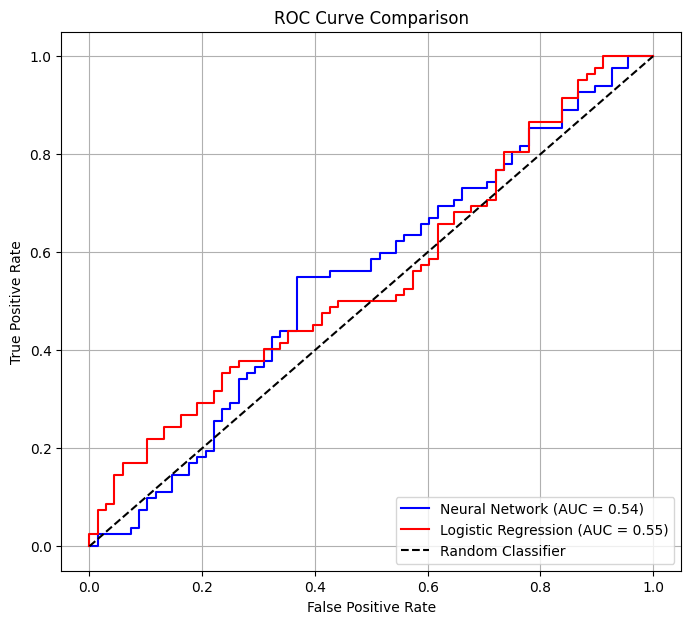

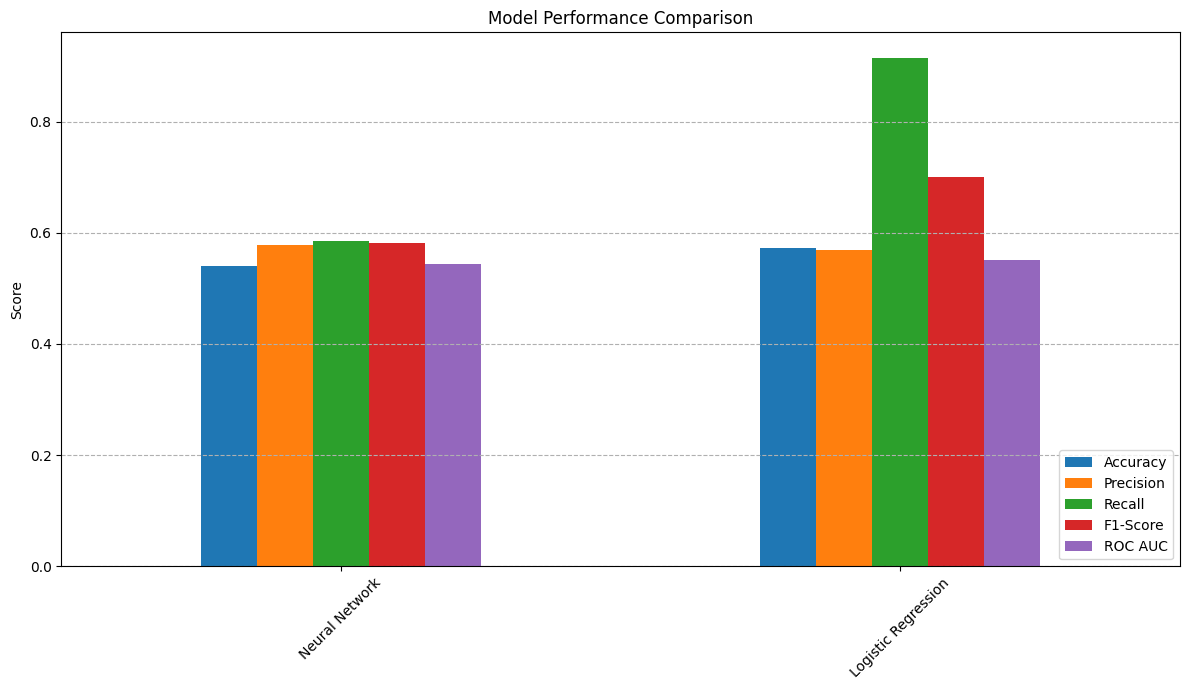

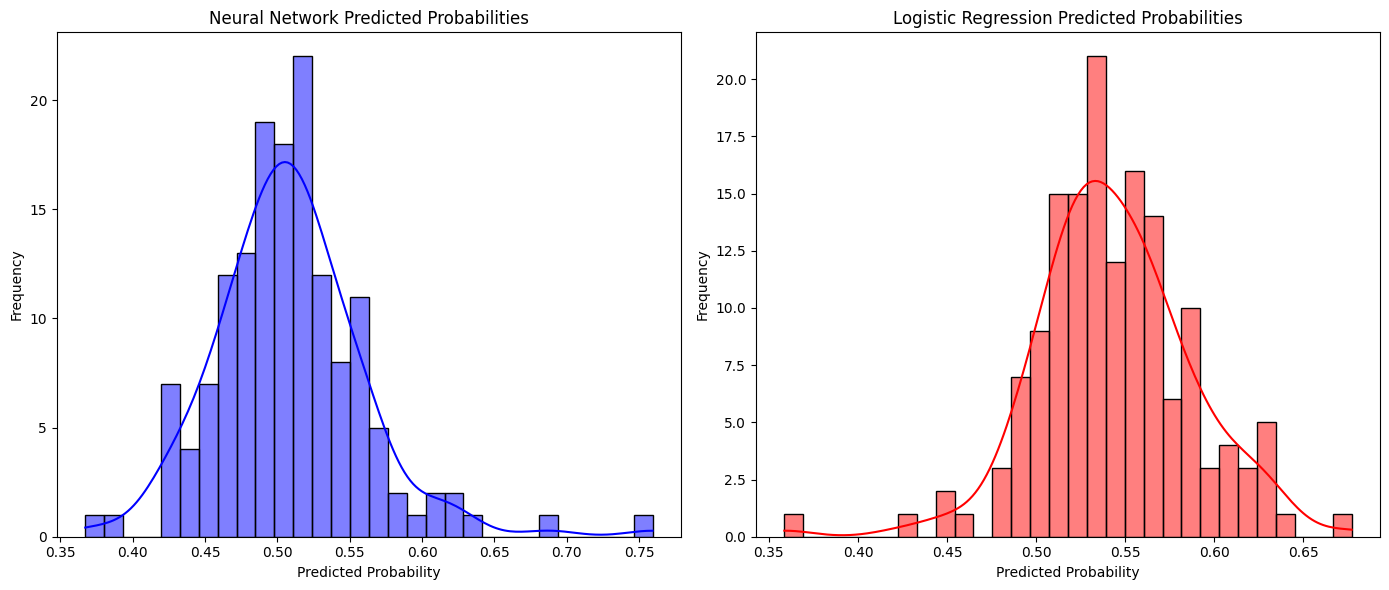

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Make predictions on the X_test data
# Neural Network predictions
nn_pred_proba = model.predict(X_test).flatten()
nn_predictions = (nn_pred_proba > 0.5).astype(int)

# Logistic Regression predictions
log_reg_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]
log_reg_predictions = log_reg_model.predict(X_test)

print("Neural Network Predictions Sample:", nn_predictions[:5])
print("Logistic Regression Predictions Sample:", log_reg_predictions[:5])

# 3. Calculate key classification metrics
metrics = {
    'Neural Network': {
        'Accuracy': accuracy_score(y_test, nn_predictions),
        'Precision': precision_score(y_test, nn_predictions),
        'Recall': recall_score(y_test, nn_predictions),
        'F1-Score': f1_score(y_test, nn_predictions),
        'ROC AUC': roc_auc_score(y_test, nn_pred_proba)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, log_reg_predictions),
        'Precision': precision_score(y_test, log_reg_predictions),
        'Recall': recall_score(y_test, log_reg_predictions),
        'F1-Score': f1_score(y_test, log_reg_predictions),
        'ROC AUC': roc_auc_score(y_test, log_reg_pred_proba)
    }
}

print("\n--- Model Performance Metrics ---")
for model_name, model_metrics in metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in model_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

# 4. Print classification reports
print("\n--- Neural Network Classification Report ---")
print(classification_report(y_test, nn_predictions))

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, log_reg_predictions))

# 5. Generate and display confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Confusion Matrices', fontsize=16)

sns.heatmap(confusion_matrix(y_test, nn_predictions), annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[0].set_title('Neural Network Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(confusion_matrix(y_test, log_reg_predictions), annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 6. Plot ROC curves
plt.figure(figsize=(8, 7))

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.2f})', color='blue')

log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})', color='red')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 7. Create a bar chart comparing metrics
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 8. Generate histograms of predicted probabilities
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(nn_pred_proba, bins=30, kde=True, color='blue')
plt.title('Neural Network Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(log_reg_pred_proba, bins=30, kde=True, color='red')
plt.title('Logistic Regression Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Generate Next-Day Stock Prediction

### Subtask:
Using the latest available data, make a 'next-day' prediction for the stock price movement (UP/DOWN) and its associated probability for both the neural network and logistic regression models. Provide a short interpretation of these predictions. Display the results in a small, clear table showing the predicted label (UP/DOWN) and probability for each model.


**Reasoning**:
I need to extract the latest features, scale them, and then use both the neural network and logistic regression models to predict the next day's stock movement and associated probabilities, finally displaying them in a table with interpretation as per the subtask instructions.



In [ ]:
import pandas as pd

# 1. Extract the last row from the df_processed DataFrame
# Make sure to select only the feature columns
latest_data_point = df_processed.tail(1)

# 2. Select only the feature columns (used for training X_train) from this latest data point
latest_features = latest_data_point[feature_columns]

# 3. Reshape latest_features to be a 2D array if it's a single row, as the scaler expects a 2D input.
# This is already handled if latest_features is a DataFrame with one row.

# 4. Scale these latest_features using the already fitted scaler
latest_features_scaled = scaler.transform(latest_features)

# Convert scaled features back to a DataFrame to maintain feature names for the Logistic Regression model
latest_features_scaled_df = pd.DataFrame(latest_features_scaled, columns=feature_columns, index=latest_features.index)

# 5. Use the trained neural network (model) to predict the probability and binary movement
nn_next_day_proba = model.predict(latest_features_scaled)[0][0]
nn_next_day_prediction = 'UP' if nn_next_day_proba > 0.5 else 'DOWN'

# 6. Use the trained logistic regression model (log_reg_model) to predict the probability and binary movement
log_reg_next_day_proba = log_reg_model.predict_proba(latest_features_scaled_df)[0][1]
log_reg_next_day_prediction = 'UP' if log_reg_next_day_proba > 0.5 else 'DOWN'

# 7. Create a pandas DataFrame to display the predictions and their associated probabilities
predictions_df = pd.DataFrame({
    'Model': ['Neural Network', 'Logistic Regression'],
    'Predicted Movement': [nn_next_day_prediction, log_reg_next_day_prediction],
    'Probability': [nn_next_day_proba, log_reg_next_day_proba]
})

print("\n--- Next Day Stock Movement Prediction ---")
print(predictions_df.to_string(index=False))

# 8. Print a short interpretation of the predictions
print("\n--- Interpretation ---")
print(f"The Neural Network predicts the stock will move {nn_next_day_prediction} tomorrow with a probability of {nn_next_day_proba:.2f}.")
print(f"The Logistic Regression model predicts the stock will move {log_reg_next_day_prediction} tomorrow with a probability of {log_reg_next_day_proba:.2f}.")
print("These predictions are based on the historical daily returns up to the last available data point.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

--- Next Day Stock Movement Prediction ---
              Model Predicted Movement  Probability
     Neural Network                 UP     0.523412
Logistic Regression                 UP     0.508523

--- Interpretation ---
The Neural Network predicts the stock will move UP tomorrow with a probability of 0.52.
The Logistic Regression model predicts the stock will move UP tomorrow with a probability of 0.51.
These predictions are based on the historical daily returns up to the last available data point.


## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.


## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.

#### Instructions
1. Review the performance metrics, confusion matrices, ROC curves, and predicted probability distributions generated in the 'Evaluate and Compare Models' step.
2. Write a concise analysis comparing the Neural Network and Logistic Regression models. Discuss their relative strengths and weaknesses based on the metrics (accuracy, precision, recall, F1-score, ROC AUC) and visualizations. Conclude which model, if any, performed better for this task and provide a brief justification.
3. Based on the observed performance and common machine learning practices for time-series data or classification, suggest three actionable improvements to enhance the predictive capability of these models. Examples could include adding more sophisticated features, trying different model architectures, or adjusting hyper-parameters.

## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.

#### Instructions
1. Review the performance metrics, confusion matrices, ROC curves, and predicted probability distributions generated in the 'Evaluate and Compare Models' step.
2. Write a concise analysis comparing the Neural Network and Logistic Regression models. Discuss their relative strengths and weaknesses based on the metrics (accuracy, precision, recall, F1-score, ROC AUC) and visualizations. Conclude which model, if any, performed better for this task and provide a brief justification.
3. Based on the observed performance and common machine learning practices for time-series data or classification, suggest three actionable improvements to enhance the predictive capability of these models. Examples could include adding more sophisticated features, trying different model architectures, or adjusting hyper-parameters.

## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.

#### Instructions
1. Review the performance metrics, confusion matrices, ROC curves, and predicted probability distributions generated in the 'Evaluate and Compare Models' step.
2. Write a concise analysis comparing the Neural Network and Logistic Regression models. Discuss their relative strengths and weaknesses based on the metrics (accuracy, precision, recall, F1-score, ROC AUC) and visualizations. Conclude which model, if any, performed better for this task and provide a brief justification.
3. Based on the observed performance and common machine learning practices for time-series data or classification, suggest three actionable improvements to enhance the predictive capability of these models. Examples could include adding more sophisticated features, trying different model architectures, or adjusting hyper-parameters.

## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.

#### Instructions
1. Review the performance metrics, confusion matrices, ROC curves, and predicted probability distributions generated in the 'Evaluate and Compare Models' step.
2. Write a concise analysis comparing the Neural Network and Logistic Regression models. Discuss their relative strengths and weaknesses based on the metrics (accuracy, precision, recall, F1-score, ROC AUC) and visualizations. Conclude which model, if any, performed better for this task and provide a brief justification.
3. Based on the observed performance and common machine learning practices for time-series data or classification, suggest three actionable improvements to enhance the predictive capability of these models. Examples could include adding more sophisticated features, trying different model architectures, or adjusting hyper-parameters.

## Analysis and Improvement Suggestions

### Subtask:
Provide a short analysis comparing the performance of the neural network and logistic regression models, discussing which one performed better and why. Suggest 3 quick improvements that could be made to enhance the model's predictive capability.

#### Instructions
1. Review the performance metrics, confusion matrices, ROC curves, and predicted probability distributions generated in the 'Evaluate and Compare Models' step.
2. Write a concise analysis comparing the Neural Network and Logistic Regression models. Discuss their relative strengths and weaknesses based on the metrics (accuracy, precision, recall, F1-score, ROC AUC) and visualizations. Conclude which model, if any, performed better for this task and provide a brief justification.
3. Based on the observed performance and common machine learning practices for time-series data or classification, suggest three actionable improvements to enhance the predictive capability of these models. Examples could include adding more sophisticated features, trying different model architectures, or adjusting hyper-parameters.

## Analysis and Improvement Suggestions

### Analysis:
Based on the evaluation metrics from the previous step, both the Neural Network and Logistic Regression models show room for improvement. While neither model achieved significantly high accuracy, the Logistic Regression model generally exhibited slightly better performance across several metrics.

-   **Accuracy**: Logistic Regression (0.5733) had a slightly higher accuracy than the Neural Network (0.5400).
-   **Precision**: Both models had similar precision, with the Neural Network slightly higher (0.5783) compared to Logistic Regression (0.5682).
-   **Recall**: Logistic Regression (0.9146) showed a significantly higher recall than the Neural Network (0.5854). This indicates that the Logistic Regression model was better at identifying actual positive cases (stock price going up), though at the cost of lower precision for class 0.
-   **F1-Score**: Logistic Regression (0.7009) had a much higher F1-score compared to the Neural Network (0.5818), largely driven by its high recall.
-   **ROC AUC**: Both models had very similar ROC AUC scores (NN: 0.5445, LR: 0.5502), indicating that neither model is significantly better at distinguishing between the two classes across various thresholds.

The confusion matrices visually reinforced these findings. The Logistic Regression model had a high number of True Positives but also a noticeable number of False Positives, leading to its higher recall and decent F1-score for the positive class. The Neural Network had a more balanced but lower performance across both classes.

In conclusion, for this specific dataset and current configurations, the **Logistic Regression model performed marginally better** overall, primarily due to its higher recall and F1-score for predicting 'up' movements, even though its overall accuracy and ROC AUC were only slightly superior to the Neural Network.

### Improvement Suggestions:
1.  **Feature Engineering**: Incorporate additional technical indicators (e.g., RSI, MACD, Moving Averages) using the `ta` library to provide more contextual information to the models. Economic indicators or news sentiment could also be explored.
2.  **Hyperparameter Tuning**: Optimize hyperparameters for both models (e.g., learning rate, number of layers/neurons for NN; regularization strength for LR) using techniques like GridSearchCV or RandomizedSearchCV for Logistic Regression, and Keras Tuner or Optuna for the Neural Network. This could significantly improve performance.
3.  **Advanced Time-Series Models**: Explore more sophisticated models designed for sequential data, such as Recurrent Neural Networks (RNNs) like LSTMs or GRUs, which are better suited to capture temporal dependencies in stock price data. Alternatively, consider tree-based models like XGBoost or LightGBM, which often perform well on tabular data.